In [1]:
import pandas as pd
import numpy as np
import ouvrai as ou
from jupyter_dash import JupyterDash
from dash import html, dash_table, dcc, ctx
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
import plotnine as p9

df, df_sub, df_frame, df_state = ou.load(
    from_pkl=False, file_regex="^data_", pickle=True
)
df_sub = ou.load_demographics(df_sub)
df_frame = ou.compute_kinematics(df_sub, df_frame)
df, df_frame = ou.find_first_velocity_peak(df, df_sub, df_frame)

Reading data_20230325_111630.json
Frame variables are: ['rhOri', 'rhPos', 'state', 't']
State change variables are: ['stateChange', 'stateChangeHeadOri', 'stateChangeHeadPos', 'stateChangeTime']
Expanded cameraGroupOri to ['cameraGroupOri_order' 'cameraGroupOri_x' 'cameraGroupOri_y'
 'cameraGroupOri_z' 'cameraGroupOri_isEuler']
Expanded cameraGroupPosn to ['cameraGroupPosn_x' 'cameraGroupPosn_y' 'cameraGroupPosn_z']
Expanded rotationOrigin to ['rotationOrigin_x' 'rotationOrigin_y' 'rotationOrigin_z']
Expanded targetPosn to ['targetPosn_x' 'targetPosn_y' 'targetPosn_z']
Expanded rhOri to ['rhOri_w' 'rhOri_x' 'rhOri_y' 'rhOri_z' 'rhOri_isQuaternion']
Expanded rhPos to ['rhPos_x' 'rhPos_y' 'rhPos_z']
Expanded stateChangeHeadOri to ['stateChangeHeadOri_w' 'stateChangeHeadOri_x' 'stateChangeHeadOri_y'
 'stateChangeHeadOri_z' 'stateChangeHeadOri_isQuaternion']
Expanded stateChangeHeadPos to ['stateChangeHeadPos_x' 'stateChangeHeadPos_y' 'stateChangeHeadPos_z']


/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:210: UserWarning: Demographics file not found. You can download it from Prolific.
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.026 m/s) for ('000', 47)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.027 m/s) for ('000', 52)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.028 m/s) for ('000', 53)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.043 m/s) for ('000', 57)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.027 m/s) for ('000', 58)
/Users/evancesanek/Documents/ouvrai/python/ouvrai/ouvrai.py:336: UserWarning: Pre-peak velocity never below pv_thresh (0.028 m/s

In [2]:
# Label the frames where the state changed
g = df_frame.groupby(["subject", "trialNumber"])["state"]
df_frame["stateChanged"] = g.transform(lambda x: x.shift(1) != x)

In [3]:
# Transform rhPos to the tip of the tool
handleLen = (
    df_frame[["subject"]].merge(
        df_sub[["subject", "handleLength"]], how="left", on="subject"
    )["handleLength"]
    / 2
)
df_frame["rhPos_x"] += df_frame["dir_x"] * handleLen.values
df_frame["rhPos_y"] += df_frame["dir_y"] * handleLen.values
df_frame["rhPos_z"] += df_frame["dir_z"] * handleLen.values

In [4]:
# X is already centered...

# Center Y (individual height calibration)
try:
    df_frame["rhPos_y_orig"]
except KeyError:
    df_frame["rhPos_y_orig"] = df_frame["rhPos_y"]

df_frame["rhPos_y"] = (
    df_frame["rhPos_y_orig"]
    - df_frame[["subject"]].merge(
        df_sub[["subject", "homePosn.y"]], how="left", on=["subject"]
    )["homePosn.y"]
)

# Center Z (same for all participants)
try:
    df_frame["rhPos_z_orig"]
except KeyError:
    df_frame["rhPos_z_orig"] = df_frame["rhPos_z"]

df_frame["rhPos_z"] = (
    df_frame["rhPos_z_orig"]
    - df_frame[["subject"]].merge(
        df_sub[["subject", "homePosn.z"]], how="left", on=["subject"]
    )["homePosn.z"]
)


In [5]:
# Merge per-trial features
try:
    df_frame[["targetId", "targetDim", "noFeedback"]]
except KeyError:
    df_frame = df_frame.merge(
        df[["subject", "trialNumber", "targetId", "targetDim", "noFeedback"]],
        how="left",
        on=["subject", "trialNumber"],
    )

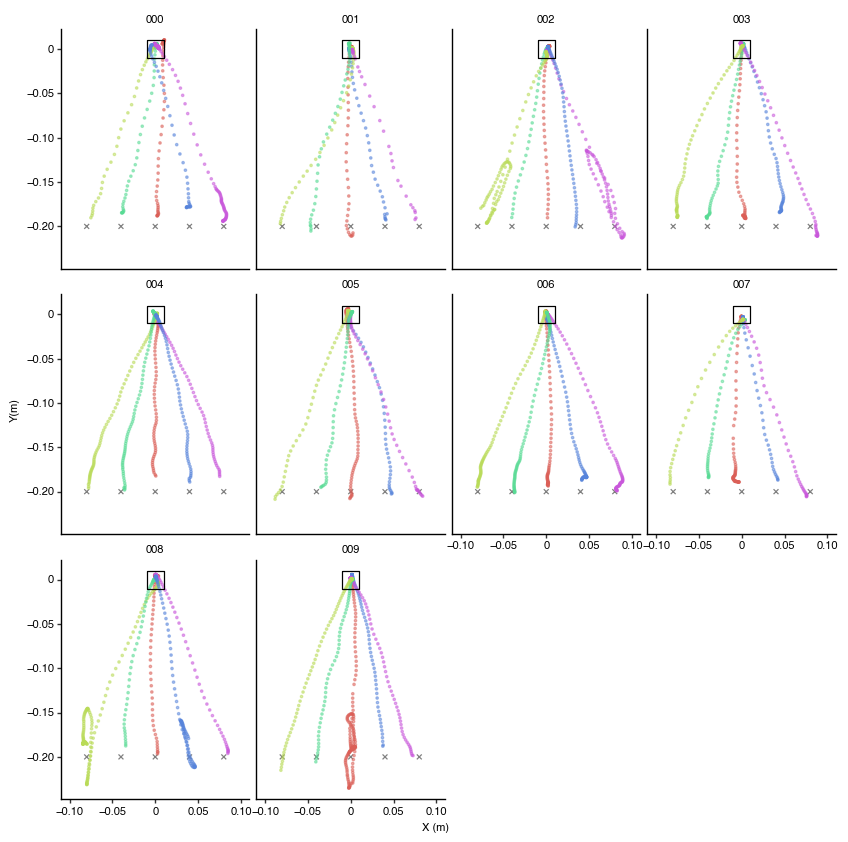

In [6]:
import plotnine as p9

x = df_frame[
    np.isin(df_frame["trialNumber"], np.arange(13, 26))
    & np.isin(df_frame["state"], ["REACH"])
    & (df_frame["targetDim"] == 0)
]
df_targets = pd.DataFrame(
    {"x": [-0.08, -0.04, 0, 0.04, 0.08], "z": [-0.2, -0.2, -0.2, -0.2, -0.2],}
)
p = (
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "z"), data=df_targets, shape="x", color="gray")
    # Trajectories
    + p9.geom_point(
        p9.aes("rhPos_x", "rhPos_z", group="trialNumber", color="factor(targetId)"),
        data=x,
        shape=".",
        alpha=0.5,
    )
    # Start cube
    + p9.geom_path(
        p9.aes("x", "y"),
        data=pd.DataFrame(
            {
                "x": [-0.01, 0.01, 0.01, -0.01, -0.01],
                "y": [0.01, 0.01, -0.01, -0.01, 0.01],
            }
        ),
    )
    + p9.theme_classic(base_family="Helvetica")
    + p9.labels.labs(x="X (m)", y="Y(m)")
    + p9.facet_wrap("subject", 3)
    + p9.xlim(-0.1, 0.1)
    + p9.theme(
        legend_position="none",
        figure_size=(10, 10),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=8, color="black"),
    )
)
fig = p.draw(show=True)


In [7]:
pre = df_frame.loc[
    df_frame["stateChanged"]
    & (df_frame["state"] == "RETURN")
    & np.isin(df_frame["cycle"], [2, 3])
    & (df_frame["targetDim"] != 2)
    & (df_frame["noFeedback"])
]
pre = (
    pre.groupby(["subject", "targetId"])[["rhPos_x", "rhPos_y", "rhPos_z"]]
    .mean()
    .reset_index()
)
pre["phase"] = 0
post = df_frame.loc[
    df_frame["stateChanged"]
    & (df_frame["state"] == "RETURN")
    & np.isin(df_frame["cycle"], [5, 6])
    & (df_frame["targetDim"] != 2)
    & (df_frame["noFeedback"])
]
post = (
    post.groupby(["subject", "targetId"])[["rhPos_x", "rhPos_y", "rhPos_z"]]
    .mean()
    .reset_index()
)
post["phase"] = 1
df_targets = pd.DataFrame(
    {
        "x": [0, -0.08, -0.04, 0.04, 0.08, 0, 0, 0, 0],
        "y": [0, 0, 0, 0, 0, -0.08, -0.04, 0.04, 0.08],
        "targetId": np.arange(0, 9),
        "phase": 0,
    }
)
df_targets = pd.concat([df_targets, df_targets.replace({"phase": 0}, 1)], axis=0)
x = pd.concat([pre, post], axis=0)
x_mean = x.groupby(["targetId", "phase"]).mean(numeric_only=True).reset_index()
p = (
    p9.ggplot(mapping=p9.aes(x="rhPos_x", y="rhPos_y"), data=x)
    + p9.facet_grid(". ~ phase")
    # + p9.stat_density_2d(
    #     p9.aes(group="factor(targetId)", fill=p9.after_stat("density")), contour=False, geom='raster'
    # )
    + p9.stat_density_2d(
        p9.aes(group="factor(targetId)", color="factor(targetId)"), levels=[350]
    )
    + p9.geom_point(p9.aes(fill="factor(targetId)"), shape="o", data=x_mean)
    + p9.geom_point(p9.aes(color="factor(targetId)"), shape=".")
    + p9.geom_point(
        p9.aes(x="x", y="y", fill="factor(targetId)"),
        shape="x",
        color="gray",
        data=df_targets,
    )
    # + p9.scale_color_brewer('qual',6)
    + p9.coords.coord_fixed(ratio=1)
    + p9.theme_classic(base_family="Helvetica")
    + p9.labels.labs(x="X (m)", y="Y (m)",)
    + p9.ylim(-0.115, 0.105)
    + p9.xlim(-0.1, 0.14)
    + p9.theme(
        legend_position="none",
        figure_size=(5, 3),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=8, color="black"),
    )
)

In [9]:
pre = df_frame.loc[
    df_frame["stateChanged"]
    & (df_frame["state"] == "RETURN")
    & np.isin(df_frame["cycle"], [2, 3])
    & (df_frame["targetDim"] != 1)
    & (df_frame["noFeedback"])
]
pre = (
    pre.groupby(["subject", "targetId"])[["rhPos_x", "rhPos_y", "rhPos_z"]]
    .mean()
    .reset_index()
)
pre["phase"] = 0
post = df_frame.loc[
    df_frame["stateChanged"]
    & (df_frame["state"] == "RETURN")
    & np.isin(df_frame["cycle"], [5, 6])
    & (df_frame["targetDim"] != 1)
    & (df_frame["noFeedback"])
]
post = (
    post.groupby(["subject", "targetId"])[["rhPos_x", "rhPos_y", "rhPos_z"]]
    .mean()
    .reset_index()
)
post["phase"] = 1
df_targets = pd.DataFrame(
    {
        "x": [0, -0.08, -0.04, 0.04, 0.08, 0, 0, 0, 0],
        "y": np.array([0, 0, 0, 0, 0, -0.08, -0.04, 0.04, 0.08]) - 0.2,
        "targetId": np.arange(0, 9),
        "phase": 0,
    }
)
df_targets = pd.concat([df_targets, df_targets.replace({"phase": 0}, 1)], axis=0)
x = pd.concat([pre, post], axis=0)
x_mean = x.groupby(["targetId", "phase"]).mean(numeric_only=True).reset_index()
p2 = (
    p9.ggplot(mapping=p9.aes(x="rhPos_x", y="rhPos_z"), data=x)
    + p9.facet_grid(". ~ phase")
    # + p9.stat_density_2d(
    #     p9.aes(group="factor(targetId)", fill=p9.after_stat("density")), contour=False, geom='raster'
    # )
    + p9.stat_density_2d(
        p9.aes(group="factor(targetId)", color="factor(targetId)"), levels=[350]
    )
    + p9.geom_point(p9.aes(fill="factor(targetId)"), shape="o", data=x_mean)
    + p9.geom_point(p9.aes(color="factor(targetId)"), shape=".")
    + p9.geom_point(
        p9.aes(x="x", y="y", fill="factor(targetId)"),
        shape="x",
        color="gray",
        data=df_targets,
    )
    # + p9.scale_color_brewer('qual',6)
    + p9.coords.coord_fixed(ratio=1)
    + p9.theme_classic(base_family="Helvetica")
    + p9.labels.labs(x="X (m)", y="Z (m)",)
    + p9.scales.scale_y_reverse()
    # + p9.ylim(-0.115, 0.105)
    + p9.xlim(-0.1, 0.14)
    + p9.theme(
        legend_position="none",
        figure_size=(5, 3),
        strip_background=p9.element_blank(),
        strip_text_y=p9.element_blank(),
        axis_ticks_minor=p9.element_blank(),
        text=p9.element_text(size=8, color="black"),
    )
)

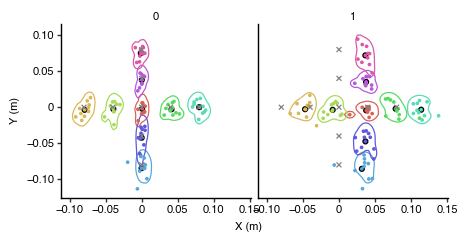

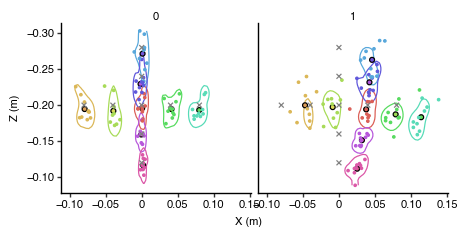

In [10]:
# Draw both generalization plots
fig = p.draw(show=True)
fig = p2.draw(show=True)